## Shrink build_tables_output

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
import warnings
warnings.filterwarnings('ignore')

In [2]:
datadir = '/home/freddy/insight/data/'
filename = datadir + 'build_tables_output_cleaned.csv'

In [3]:
df = pd.read_csv(filename)
nrows0 = df.shape[0]

In [4]:
df=df[df.terrain != 'Multi']

In [5]:
df=df.drop(columns=['Unnamed: 0'], axis=1)

In [6]:
cols = ['age_group','name','sex', 'race_title', 
        'terrain', 'race_date', 'meeting_id','event_title']

In [7]:
for i in cols:
    df = df[pd.notnull(df[i])]

In [8]:
# Make it huge b/c I will find min later
df['chip_time'].fillna('100:59:59', inplace=True)
df['gun_time'].fillna('100:59:59', inplace=True)

In [9]:
nrows1 = df.shape[0]
frac = (1-nrows1/nrows0)*100
print('percent lost = %1.3f%%' % frac)

percent lost = 27.307%


In [11]:
dft=df[df.race_title == 'Mar']
marathons = dft.groupby(['meeting_id','event_title','race_date'],as_index=False).count()
# Write out the averaged time bands
marathons.to_csv('explore_marathons.csv',sep=',',index=False)
mardict = dict(zip(marathons.meeting_id,marathons.event_title))
f3 = open('explore_marathons.csv', 'w')
f3.write('ID,event\n')
for key, val in mardict.items():
    f3.write('%d,%s\n'%(key,val))
f3.close()

In [10]:
def cut_up_url(url):
    flag = 'meetingid='
    start = url.find(flag)+len(flag) 
    end   = url.find('&')
    substr = url[start:end]
    return int(substr)

In [11]:
def handle_gpx(filename):
    gpx = pd.read_csv(filename, header=0)
    gpx['meeting_id'] = gpx['URL'].apply(lambda x: cut_up_url(x))
    #gpx.rename(index=str, columns={'race_data':'race_date'})
    return gpx
#gpx = handle_gpx(datadir + 'gpx_discover.csv')
#gpx_IDs = gpx['meeting_id'].tolist()

In [12]:
def cleaned_gpx(filename):
    gpx = pd.read_csv(filename, header=0)
    return gpx

In [17]:
gpx = cleaned_gpx(datadir + 'gpx_elevation_map_new.csv')

In [19]:
# Make everything unique, and then find the overlap
IDs = df['meeting_id'].tolist()
gpx_IDs = gpx['meeting_id'].tolist()
uniqueIDs = set(IDs)
gpx_uniqueIDs = set(gpx_IDs)
overlapIDs = list(uniqueIDs & gpx_uniqueIDs)
print('Found %d GPX files with overlapping IDs' % len(overlapIDs))

Found 176 GPX files with overlapping IDs


## For now, only consider races that have a corresponding GPX file.

In [20]:
dfnew = df[df['meeting_id'].isin(overlapIDs)]
gpxnew = gpx[gpx['meeting_id'].isin(overlapIDs)]
nrows0 = dfnew.shape[0]

In [21]:
# For some reason these are floats... 
dfnew.meeting_id = dfnew.meeting_id.astype(int)
dfnew.uniqueID = dfnew.uniqueID.astype(int)

In [29]:
# Lets make our life easier and remove the following race types
races2delete = ['1.2KNAD U15','1.2KNAD U17','1.5K U11','10KNAD',
                '12MNAD','3K U13','3K U15','5K A','5K B','5K E',
                '5K FR','5KNAD','5MNAD','5MWC','6MNAD', 'MarNAD']

In [30]:
dfnew = dfnew[~dfnew['race_title'].isin(races2delete)]
nrows1 = dfnew.shape[0]
dfnew.groupby(['race_title'],as_index=False).size()
frac = (1-nrows1/nrows0)*100
print('percent lost = %1.3f%%' % frac)

percent lost = 3.313%


### Convert race_title to a mileage

In [31]:
distmap= {'1M':1.0, '3K':1.86, '2M':2.0, '5K':3.1, '4M':4.0,
          '5M':5.0, '6M':6.0, '10K':6.2, 'QM':6.55, '7M':7.0, '10M':10.0,
          'HM':13.1, 'Mar':26.2}

In [32]:
def distance(t):
    return distmap[t]

In [33]:
dfnew['race_dist'] = dfnew['race_title'].apply(lambda x: distance(x))

In [34]:
def fix_time(t):
    parts = t.split(':')
    ncolons = t.count(':')
    if ncolons == 1:
        return t
    elif ncolons == 2:
        min = int(parts[0])*60 + int(parts[1])
        return str(min) + ':' + parts[2]
    else:
        return '10000:00'

In [35]:
# The chip/gun times are inconsistent
dfnew['chip_time_corr']=dfnew['chip_time'].apply(lambda x: fix_time(str(x)))
dfnew['gun_time_corr']=dfnew['gun_time'].apply(lambda x: fix_time(str(x)))

In [36]:
# Let's make a new column that takes the min of chip/gun,
# make it a float so we can plot later - units = minutes
def find_min_time(row):
    # There should be a gun-time for everyone, but chip time has been
    # set to something large
    chip = row['chip_time_corr'].split(':')
    gun = row['gun_time_corr'].split(':')
    # convert to seconds, compare immediately
    chiptime = int(chip[0])*60 + int(chip[1])
    guntime  = int(gun[0])*60 + int(gun[1])
    time = guntime if (guntime <= chiptime) else chiptime
    return float(time)/60.0 # convert back to minutes

In [37]:
dfnew['min_time'] = dfnew.apply(find_min_time,axis=1)

In [38]:
#dfnew.loc[dfnew.race_title=='10k','race_title'] = '10K'
#dfnew=dfnew[dfnew.race_title == '10K']
#norm = 10.0 * 1.0
gpx_up = dict(zip(gpxnew.meeting_id, gpxnew.sum_up))
gpx_down = dict(zip(gpxnew.meeting_id, gpxnew.sum_down))
#gpx_mean = dict(zip(gpxnew.meeting_id, gpxnew['mean']))
gpx_sigma = dict(zip(gpxnew.meeting_id, gpxnew.sigma))
dfnew['sum_up']=dfnew['meeting_id'].apply(lambda x:   gpx_up[x])
dfnew['sum_down']=dfnew['meeting_id'].apply(lambda x: -1.0*gpx_down[x])
#dfnew['mean']=dfnew['meeting_id'].apply(lambda x:     gpx_mean[x])
dfnew['sigma']=dfnew['meeting_id'].apply(lambda x:    gpx_sigma[x])

In [39]:
dfnew['diff'] = dfnew['sum_up'] - dfnew['sum_down']

In [40]:
dftemp = dfnew

In [41]:
#dftemp.head()

In [42]:
columns2drop = ['chip_time','gun_time','name',
                'terrain','race_date','uniqueID',
               'chip_time_corr','gun_time_corr', 'sum_down']
dfnew = dfnew.drop(columns2drop, axis=1)

In [43]:
dfnew.to_csv('data_overlaps_with_gpx_cleaned.csv',sep=',')

In [44]:
temp=dfnew.groupby(['meeting_id','race_title','race_dist',
                   'age_group','sex'],as_index=False)['min_time'].median()

In [45]:
races = list(set(dfnew['race_title'].tolist()))
print('%d types of races' % len(races))

13 types of races


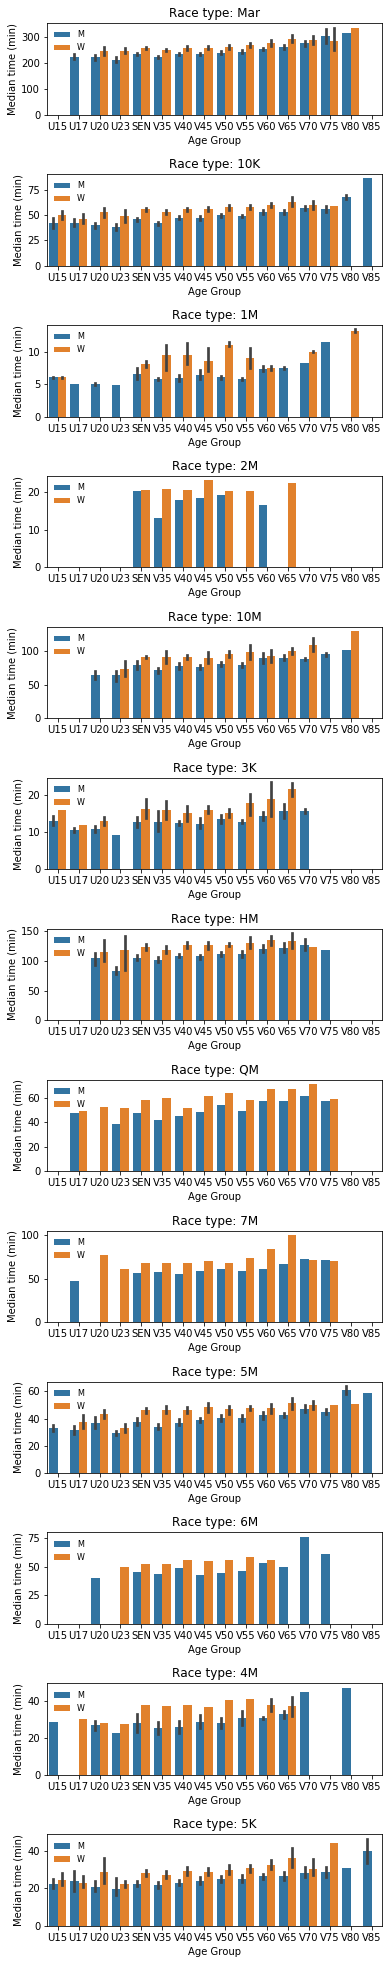

In [46]:
age_order = ['U15','U17','U20','U23','SEN','V35','V40','V45',
             'V50','V55','V60','V65','V70','V75','V80','V85']
f, axes = plt.subplots(13, 1, figsize=(6,35))
plt.subplots_adjust(left=None, bottom=None, right=None, 
                top=None, wspace=None, hspace=0.65)
for i in range(0,13):
    sns.barplot(data=temp[temp.race_title == races[i]],
                x='age_group',y='min_time', hue='sex', 
                order=age_order, hue_order=['M','W'], ax=axes[i])
    axes[i].set_xlabel('Age Group')
    axes[i].set_ylabel('Median time (min)')
    axes[i].legend(frameon=False, loc='upper left', prop={'size':8})
    axes[i].set_title('Race type: %s' % str(races[i]))


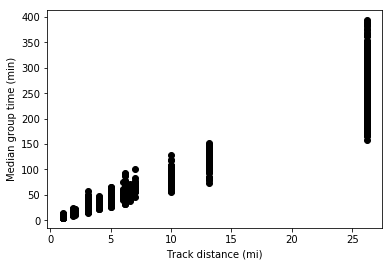

In [47]:
plt.scatter(temp['race_dist'], temp['min_time'],color='black')
plt.xlabel('Track distance (mi)')
plt.ylabel('Median group time (min)')
plt.show()

In [49]:
sigmas=dfnew.groupby(['meeting_id','sigma', 'sum_up','race_title'],as_index=False)['min_time'].median()

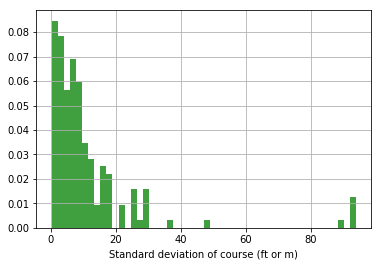

In [50]:
n, bins, patches = plt.hist(sigmas['sigma'], 50, density=True, 
                            facecolor='g', alpha=0.75)
plt.grid(True)
plt.xlabel('Standard deviation of course (ft or m)')
plt.show()

Text(3.675,0.5,'Median Finish Time (min)')

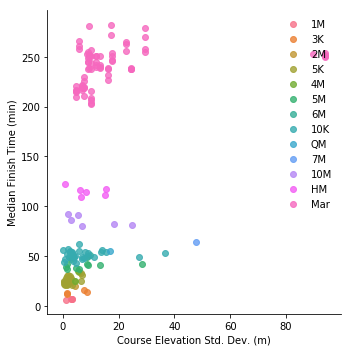

In [51]:
race_order= ['1M', '3K', '2M', '5K', '4M',
            '5M', '6M', '10K', 'QM', '7M', '10M',
            'HM', 'Mar']
sns.lmplot(data=sigmas,x='sigma',y='min_time', 
           hue='race_title', hue_order=race_order,
          fit_reg=False, legend=False)
plt.legend(frameon=False, loc='upper right', prop={'size':10})
plt.xlabel('Course Elevation Std. Dev. (m)')
plt.ylabel('Median Finish Time (min)')

Text(3.675,0.5,'Median Finish Time (min)')

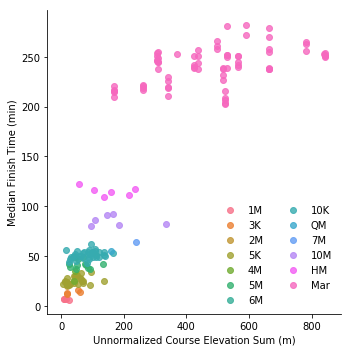

In [53]:
sns.lmplot(data=sigmas,x='sum_up',y='min_time', 
           hue='race_title', hue_order=race_order,
          fit_reg=False, legend=False)
plt.legend(frameon=False, ncol=2,loc='top left', prop={'size':10})
plt.xlabel('Unnormalized Course Elevation Sum (m)')
plt.ylabel('Median Finish Time (min)')